In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [6]:
df_location = pd.read_excel('../../python/df_location.xlsx')
df_distance = pd.read_excel('../../python/df_distance_km.xlsx')
df_vehicle = pd.read_excel('../../python/df_vehicle.xlsx')
df_orders = pd.read_excel('../../python/df_orders.xlsx')

In [7]:
df_location.shape

(21, 3)

In [8]:
df_distance.shape

(21, 21)

In [9]:
df_vehicle.shape

(6, 4)

[{'vehiculo_id': np.float64(2.0), 'capacity_used': np.int64(3808), 'route': [0, 1, 2, 3], 'cost': np.float64(4.265632000000001)}, {'vehiculo_id': np.float64(6.0), 'capacity_used': np.int64(2811), 'route': [4, 5, 6], 'cost': np.float64(3.9445000000000006)}, {'vehiculo_id': np.float64(4.0), 'capacity_used': np.int64(2770), 'route': [7, 8, 9], 'cost': np.float64(10.143359)}, {'vehiculo_id': np.float64(1.0), 'capacity_used': np.int64(1916), 'route': [10, 11], 'cost': np.float64(3.94678)}, {'vehiculo_id': np.float64(3.0), 'capacity_used': np.int64(4679), 'route': [12, 13, 14, 15, 16], 'cost': np.float64(9.71398)}, {'vehiculo_id': np.float64(5.0), 'capacity_used': np.int64(2754), 'route': [17, 18, 19], 'cost': np.float64(21.4248)}]
[{'vehiculo_id': np.float64(2.0), 'best_route': ['Cliente_4', 'Cliente_1', 'Cliente_2', 'Cliente_3'], 'best_cost': np.float64(4.118170000000001)}, {'vehiculo_id': np.float64(6.0), 'best_route': ['Cliente_6', 'Cliente_7', 'Cliente_5'], 'best_cost': np.float64(2.117

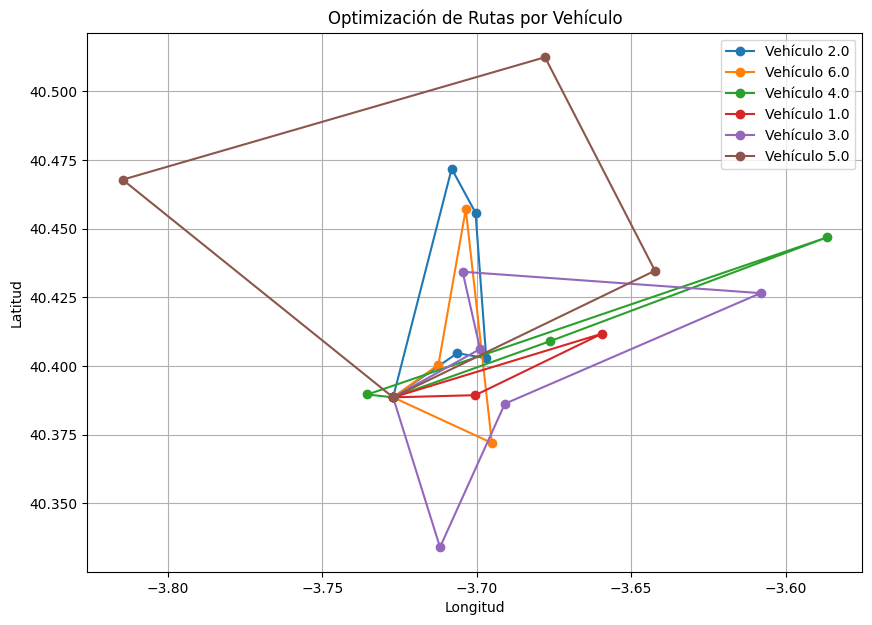

In [14]:
# Configuración inicial
distance_matrix_with_warehouse = df_distance.values
df_location_filtered = df_location[df_location["cliente"] != "Almacén"]
clients = list(range(len(df_location_filtered)))
total_order_demand = df_orders["order_demand"].sum()

# Función para calcular el costo total de una ruta, incluyendo el almacén
def calculate_vehicle_cost_with_warehouse(route, vehicle_id):
    vehicle = df_vehicle.loc[df_vehicle["vehiculo_id"] == vehicle_id].iloc[0]
    cost_per_km = vehicle["costo_km"]
    total_distance = distance_matrix_with_warehouse[-1, route[0]]  # Desde el almacén al primer cliente
    for i in range(len(route) - 1):
        total_distance += distance_matrix_with_warehouse[route[i], route[i + 1]]
    total_distance += distance_matrix_with_warehouse[route[-1], -1]  # Desde el último cliente al almacén
    return total_distance * cost_per_km



# Asignar vehículos en base a costo y capacidad
remaining_demand = total_order_demand
used_vehicles = []

for _, row in df_vehicle.sort_values(by="costo_km").iterrows():
    if remaining_demand <= 0:
        break
    vehicle_id = row["vehiculo_id"]
    capacity = row["capacidad_kg"]
    current_capacity_used = 0
    current_route = []
    for client in clients[:]:
        client_name = f"Cliente_{client + 1}"
        if client_name in df_orders["cliente"].values:
            client_demand = df_orders.loc[df_orders["cliente"] == client_name, "order_demand"].values[0]
            if current_capacity_used + client_demand <= capacity:
                current_route.append(client)
                current_capacity_used += client_demand
                clients.remove(client)
    if current_route:
        route_cost = calculate_vehicle_cost_with_warehouse(current_route, vehicle_id)
        used_vehicles.append({
            "vehiculo_id": vehicle_id,
            "capacity_used": current_capacity_used,
            "route": current_route,
            "cost": route_cost,
        })
        remaining_demand -= current_capacity_used
print(used_vehicles)
# Algoritmo genético para optimizar rutas
def genetic_algorithm_for_vehicle(vehicle, generations=200, population_size=100, mutation_rate=0.1):
    clients = vehicle["route"]
    vehicle_id = vehicle["vehiculo_id"]

    def calculate_fitness(route):
        return 1 / calculate_vehicle_cost_with_warehouse(route, vehicle_id)
    
    def initialize_population():
        return [random.sample(clients, len(clients)) for _ in range(population_size)]
    
    def crossover(parent1, parent2):
        size = len(parent1)
        start, end = sorted(random.sample(range(size), 2))
        child = [-1] * size
        child[start:end] = parent1[start:end]
        ptr = end
        for gene in parent2:
            if gene not in child:
                if ptr == size:
                    ptr = 0
                child[ptr] = gene
                ptr += 1
        return child
    
    def mutate(route):
        size = len(route)
        idx1, idx2 = random.sample(range(size), 2)
        route[idx1], route[idx2] = route[idx2], route[idx1]

    def select_parents(population, fitness_scores):
        total_fitness = sum(fitness_scores)
        probabilities = [score / total_fitness for score in fitness_scores]
        parent_indices = np.random.choice(len(population), size=2, p=probabilities)
        return population[parent_indices[0]], population[parent_indices[1]]
    
    population = initialize_population()

    for _ in range(generations):
        fitness_scores = [calculate_fitness(ind) for ind in population]
        new_population = []
        best_routes = [x for _, x in sorted(zip(fitness_scores, population), reverse=True)][:5]
        new_population.extend(best_routes)
        while len(new_population) < population_size:
            parent1, parent2 = select_parents(population, fitness_scores)
            child = crossover(parent1, parent2)
            if random.random() < mutation_rate:
                mutate(child)
            new_population.append(child)
        population = new_population

    best_fitness = max(fitness_scores)
    best_route = population[fitness_scores.index(best_fitness)]
    best_cost = 1 / best_fitness
    return best_route, best_cost

# Optimizar rutas para todos los vehículos
optimized_routes = []
for vehicle in used_vehicles:
    best_route, best_cost = genetic_algorithm_for_vehicle(vehicle)
    optimized_routes.append({
        "vehiculo_id": vehicle["vehiculo_id"],
        "best_route": [f"Cliente_{client + 1}" for client in best_route],
        "best_cost": best_cost,
    })

print(optimized_routes)

# Visualizar rutas
def plot_routes(optimized_routes, df_location_filtered):
    plt.figure(figsize=(10, 7))
    for route_data in optimized_routes:
        route = route_data["best_route"]
        vehicle_id = route_data["vehiculo_id"]
        route_coords = [df_location_filtered.loc[df_location_filtered["cliente"] == r, ["Latitud", "Longitud"]].values[0] for r in route]
        route_coords.insert(0, df_location.loc[df_location["cliente"] == "Almacén", ["Latitud", "Longitud"]].values[0])
        route_coords.append(df_location.loc[df_location["cliente"] == "Almacén", ["Latitud", "Longitud"]].values[0])
        route_coords = np.array(route_coords)
        plt.plot(route_coords[:, 1], route_coords[:, 0], marker='o', label=f"Vehículo {vehicle_id}")

    plt.title("Optimización de Rutas por Vehículo")
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.legend()
    plt.grid()
    plt.show()

plot_routes(optimized_routes, df_location_filtered)
